<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/text_embedding_limitations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --quiet neo4j langchain-community langchain-openai

In [1]:
import os
from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings
import getpass

In [2]:
os.environ["NEO4J_URI"] = "bolt://44.204.178.84:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "minimums-triangle-saving"

graph = Neo4jGraph(refresh_schema=False)

/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key: ········


In [13]:
graph.query("""
MATCH (m:Movie)
WHERE m.imdbRating IS NOT NULL
WITH m
ORDER BY m.imdbRating DESC
LIMIT 1000
SET m:Target
""")

[]

In [18]:
graph.query("""MATCH (m:Target) RETURN m LIMIT 1""")

[{'m': {'languages': ['English'],
   'year': 1995,
   'imdbId': '0114709',
   'runtime': 81,
   'imdbRating': 8.3,
   'movieId': '1',
   'countries': ['USA'],
   'imdbVotes': 591836,
   'title': 'Toy Story',
   'url': 'https://themoviedb.org/movie/862',
   'revenue': 373554033,
   'tmdbId': '862',
   'plot': "A cowboy doll is profoundly threatened and jealous when a new spaceman figure supplants him as top toy in a boy's room.",
   'poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg',
   'released': '1995-11-22',
   'budget': 30000000}}]

In [28]:
embedding = OpenAIEmbeddings(model="text-embedding-3-small")

neo4j_vector = Neo4jVector.from_existing_graph(
    embedding=embedding,
    index_name="movies",
    node_label="Target",
    text_node_properties=["plot", "title", "year", "imdbRating"],
    embedding_node_property="embedding",
)

Failed to write data to connection IPv4Address(('44.204.178.84', 7687)) (ResolvedIPv4Address(('44.204.178.84', 7687)))


In [25]:
neo4j_vector.similarity_search("What is a movie where a little boy meets his hero?")

[Document(metadata={'budget': 70000000, 'movieId': '2761', 'tmdbId': '10386', 'imdbVotes': 123948, 'runtime': 86, 'countries': ['USA'], 'imdbId': '0129167', 'url': 'https://themoviedb.org/movie/10386', 'released': '1999-08-06', 'languages': ['English'], 'poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/dUFiLEEuTZyUiQrN6oYMbMtDaXD.jpg', 'revenue': 23159305}, page_content='\nplot: A young boy befriends a giant robot from outer space that a paranoid government agent wants to destroy.\ntitle: Iron Giant, The\nyear: 1999\nimdbRating: 8.0'),
 Document(metadata={'budget': 8000000, 'movieId': '1259', 'tmdbId': '235', 'imdbVotes': 261725, 'runtime': 89, 'countries': ['USA'], 'imdbId': '0092005', 'url': 'https://themoviedb.org/movie/235', 'released': '1986-08-22', 'languages': ['English'], 'poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/vz0w9BSehcqjDcJOjRaCk7fgJe7.jpg', 'revenue': 52287414}, page_content='\nplot: After the death of a friend, a writer recounts a boyhood journey to

In [26]:
neo4j_vector.similarity_search("Which movies are from year 2016?")

[Document(metadata={'budget': 4000000, 'movieId': '116897', 'tmdbId': '265195', 'imdbVotes': 76453, 'runtime': 122, 'countries': ['Argentina', ' Spain'], 'imdbId': '3011894', 'url': 'https://themoviedb.org/movie/265195', 'released': '2014-08-21', 'languages': ['Spanish'], 'poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/pvSty5MCAxdj8LlAEXCDfM1YNOl.jpg', 'revenue': 27007072}, page_content='\nplot: Six short stories that explore the extremities of human behavior involving people in distress.\ntitle: Wild Tales\nyear: 2014\nimdbRating: 8.1'),
 Document(metadata={'budget': 120000000, 'movieId': '97938', 'tmdbId': '87827', 'imdbVotes': 420635, 'runtime': 127, 'countries': ['USA', ' Taiwan', ' UK'], 'imdbId': '0454876', 'url': 'https://themoviedb.org/movie/87827', 'released': '2012-11-21', 'languages': ['English', ' Tamil', ' French', ' Japanese', ' Hindi', ' Chinese'], 'poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/mYDKm9HxImm8PRru3KbkHAe1cmk.jpg', 'revenue': 609016565}, p

In [30]:
neo4j_hybrid = Neo4jVector.from_existing_graph(
    embedding=OpenAIEmbeddings(model="text-embedding-3-small"),
    index_name="movies",
    node_label="Target",
    text_node_properties=["plot", "title", "year", "imdbRating"],
    embedding_node_property="embedding",
    search_type='hybrid'
)

neo4j_hybrid.similarity_search("Which movies are from year 2016?")

[Document(metadata={'budget': 4000000, 'tmdbId': '265195', 'movieId': '116897', 'imdbVotes': 76453, 'runtime': 122, 'countries': ['Argentina', ' Spain'], 'imdbId': '3011894', 'url': 'https://themoviedb.org/movie/265195', 'released': '2014-08-21', 'languages': ['Spanish'], 'poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/pvSty5MCAxdj8LlAEXCDfM1YNOl.jpg', 'revenue': 27007072}, page_content='\nplot: Six short stories that explore the extremities of human behavior involving people in distress.\ntitle: Wild Tales\nyear: 2014\nimdbRating: 8.1'),
 Document(metadata={'tmdbId': '114524', 'movieId': '26655', 'imdbVotes': 492, 'runtime': 79, 'countries': ['USA'], 'imdbId': '0097099', 'url': 'https://themoviedb.org/movie/114524', 'released': '1990-10-26', 'languages': ['English'], 'poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/tAmvWQl1R0uiydLnG0o9PgRyanS.jpg'}, page_content='\nplot: A collection of profiles of people dead from AIDS who are remembered in the AIDS Memorial Quilt.\n

In [33]:
graph.query("""MATCH (m:Target) WHERE m.year = 2016 RETURN m.title AS title""")

[{'title': 'Deadpool'},
 {'title': 'Zootopia'},
 {'title': 'Sing Street'},
 {'title': 'Author: The JT LeRoy Story'}]

In [27]:
neo4j_vector.similarity_search("Which movie has the highest imdb score?")

[Document(metadata={'budget': 2540800, 'movieId': '899', 'tmdbId': '872', 'imdbVotes': 144026, 'runtime': 103, 'countries': ['USA'], 'imdbId': '0045152', 'url': 'https://themoviedb.org/movie/872', 'released': '1952-04-11', 'languages': ['English'], 'poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/w03EiJVHP8Un77boQeE7hg9DVdU.jpg', 'revenue': 7200000}, page_content="\nplot: A silent film production company and cast make a difficult transition to sound.\ntitle: Singin' in the Rain\nyear: 1952\nimdbRating: 8.3"),
 Document(metadata={'movieId': '7979', 'tmdbId': '42632', 'imdbVotes': 2179, 'runtime': 78, 'countries': ['USA'], 'imdbId': '0064689', 'url': 'https://themoviedb.org/movie/42632', 'released': '1969-06-02', 'languages': ['English'], 'poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/wEB3c5Y5spAHOQaFWcsfFky3SWb.jpg'}, page_content='\nplot: A film about the greatest pre-Woodstock rock music festival.\ntitle: Monterey Pop\nyear: 1968\nimdbRating: 8.1'),
 Document(metadat

In [34]:
graph.query("""MATCH (m:Target) RETURN m.title AS title, m.imdbRating AS rating ORDER BY rating DESC LIMIT 4""")

[{'title': 'Band of Brothers', 'rating': 9.6},
 {'title': 'Civil War, The', 'rating': 9.5},
 {'title': 'Shawshank Redemption, The', 'rating': 9.3},
 {'title': 'Cosmos', 'rating': 9.3}]

In [36]:
neo4j_vector.similarity_search("How many movies are from the year 2015?")

[Document(metadata={'budget': 245000000, 'movieId': '122886', 'tmdbId': '140607', 'imdbVotes': 457987, 'runtime': 135, 'countries': ['USA'], 'imdbId': '2488496', 'url': 'https://themoviedb.org/movie/140607', 'released': '2015-12-18', 'languages': ['English'], 'poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg', 'revenue': 2068223624}, page_content='\nplot: Three decades after the defeat of the Galactic Empire, a new threat arises. The First Order attempts to rule the galaxy and only a ragtag group of heroes can stop them, along with the help of the Resistance.\ntitle: Star Wars: Episode VII - The Force Awakens\nyear: 2015\nimdbRating: 8.4'),
 Document(metadata={'budget': 4000000, 'movieId': '27800', 'tmdbId': '11049', 'imdbVotes': 10885, 'runtime': 68, 'countries': ['Japan', ' France'], 'imdbId': '0368667', 'url': 'https://themoviedb.org/movie/11049', 'released': '2003-05-28', 'languages': ['English'], 'poster': 'https://image.tmdb.org/t/p/w440_and

In [37]:
graph.query("""MATCH (m:Target) WHERE m.year = 2015 RETURN count(*)""")

[{'count(*)': 20}]

In [32]:
from pydantic import BaseModel, Field
from typing import Optional, Dict, List
from langchain_core.tools import tool

class MovieCountInput(BaseModel):
    min_year: Optional[int] = Field(description="Minimum release year of the movies")
    max_year: Optional[int] = Field(description="Maximum release year of the movies")
    min_rating: Optional[float] = Field(description="Minimum imdb rating")


@tool("movie-count", args_schema=MovieCountInput, return_direct=True)
def movie_count(min_year: Optional[int], max_year: Optional[int], min_rating: Optional[float]) -> int:
    """Calculate the count of movies based on particular filters"""
    cypher_statement = "MATCH (t:Target) "
    filters = []
    params = {}
    if min_year:
        filters.append("t.year >= $min_year")
        params['min_year'] = min_year
    if max_year:
        filters.append("t.year <= $max_year")
        params['max_year'] = max_year
    if min_rating:
        filters.append("t.imdbRating >= $min_rating")
        params['min_rating'] = min_rating
    if filters:
        cypher_statement += "WHERE " 
        cypher_statement += " AND ".join(filters)
    # Add return
    cypher_statement += " RETURN count(t) AS movie_count"
    print(cypher_statement)
    data = graph.query(cypher_statement, params=params)
    return data


In [39]:
class MovieListInput(BaseModel):
    sort_by: str = Field(description="How to sort movies, can be one of either latest, rating", enum=['latest', 'rating'])
    description: Optional[str] = Field(description="Description of the movies")
    min_year: Optional[int] = Field(description="Minimum release year of the movies")
    max_year: Optional[int] = Field(description="Maximum release year of the movies")
    min_rating: Optional[float] = Field(description="Minimum imdb rating")


@tool("movie-list", args_schema=MovieListInput, return_direct=True)
def movie_list(description: Optional[str], min_year: Optional[int], max_year: Optional[int], min_rating: Optional[float], sort_by: Optional[str] = 'rating') -> List[Dict]:
    """List movies based on particular filters"""
    # We can only use vector index if no prefiltering
    if description and not min_year and not max_year and not min_rating:
        print("Vector only")
        return neo4j_vector.similarity_search(description)
    cypher_statement = "MATCH (t:Target) "
    filters = []
    params = {}
    if min_year:
        filters.append("t.year >= $min_year")
        params['min_year'] = min_year
    if max_year:
        filters.append("t.year <= $max_year")
        params['max_year'] = max_year
    if min_rating:
        filters.append("t.imdbRating >= $min_rating")
        params['min_rating'] = min_rating
    if filters:
        cypher_statement += "WHERE " 
        cypher_statement += " AND ".join(filters)
    # Add return
    cypher_statement += " RETURN t.title AS title, t.year AS year, t.imdbRating AS rating ORDER BY "
    # if it is description, it has priority for sorting
    if description:
        cypher_statement += "vector.similarity.cosine(t.embedding, $embedding) DESC "
        params['embedding'] = embedding.embed_query(description)
    elif sort_by == 'rating':
        cypher_statement += "t.imdbRating DESC "
    else: # sort by latest
        cypher_statement += "t.year DESC "
    cypher_statement += " LIMIT 4"
    print(cypher_statement)
    data = graph.query(cypher_statement, params=params)
    return data


In [40]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4-turbo')

tools = [movie_count, movie_list]
llm_with_tools = llm.bind_tools(tools)

In [41]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with finding and explaining relevant information about movies.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

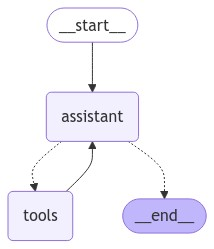

In [42]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [43]:
messages = [HumanMessage(content="What are the latest movies about a girl meeting her hero?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

Vector only
================================ Human Message =================================

What are the latest movies about a girl meeting her hero?
================================== Ai Message ==================================
Tool Calls:
  movie-list (call_glZT3090F9Ax9AWMoaq4xsn2)
 Call ID: call_glZT3090F9Ax9AWMoaq4xsn2
  Args:
    sort_by: latest
    description: girl meeting her hero
    min_year: None
    max_year: None
    min_rating: None
================================= Tool Message =================================
Name: movie-list

[Document(metadata={'movieId': '26903', 'tmdbId': '37797', 'imdbVotes': 28132, 'runtime': 111, 'countries': ['Japan'], 'imdbId': '0113824', 'url': 'https://themoviedb.org/movie/37797', 'released': '1995-07-15', 'languages': ['Japanese', ' English'], 'poster': 'https://image.tmdb.org/t/p/w440_and_h660_face/7oQgBscjpNLgOCaU1nBVSjWdIrC.jpg'}, page_content='\nplot: A love story between a girl who loves reading books, and the boy who has previous

In [44]:
messages = [HumanMessage(content="What are the movies from the 90s about a girl meeting her hero?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

MATCH (t:Target) WHERE t.year >= $min_year AND t.year <= $max_year RETURN t.title AS title, t.year AS year, t.imdbRating AS rating ORDER BY vector.similarity.cosine(t.embedding, $embedding) DESC  LIMIT 4
================================ Human Message =================================

What are the movies from the 90s about a girl meeting her hero?
================================== Ai Message ==================================
Tool Calls:
  movie-list (call_Mq37Fm5Qs01qQ961T8QRaFqw)
 Call ID: call_Mq37Fm5Qs01qQ961T8QRaFqw
  Args:
    description: girl meeting her hero
    min_year: 1990
    max_year: 1999
    min_rating: None
    sort_by: rating
================================= Tool Message =================================
Name: movie-list

[{"title": "Whisper of the Heart (Mimi wo sumaseba)", "year": 1995, "rating": 8.0}, {"title": "Léon: The Professional (a.k.a. The Professional) (Léon)", "year": 1994, "rating": 8.6}, {"title": "Breaking the Waves", "year": 1996, "rating": 7.9}, {"

In [26]:
messages = [HumanMessage(content="How many movies from the 90s have the rating higher than 9.1?")]
react_graph.invoke({"messages": messages})

MATCH (t:Target) WHERE t.year >= $min_year AND t.year <= $max_year AND t.imdbRating >= $min_rating RETURN count(t) AS movie_count


{'messages': [HumanMessage(content='How many movies from the 90s have the rating higher than 9.1?', additional_kwargs={}, response_metadata={}, id='9462f857-1c5a-4651-b2ed-d9417a9297e3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ps6B31cail76ibFdMmSV02Np', 'function': {'arguments': '{"min_year":1990,"max_year":1999,"min_rating":9.1}', 'name': 'movie-count'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 120, 'total_tokens': 149, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_22b855c4b7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d863f3d4-5160-4d45-b954-53280ebd7f6f-0', tool_calls=[{'name': 'movie-count', 'args': {'min_year': 1990, 'max_year': 1999, 'min_rating': 9.1}, 'id': 'call_ps6B31cail76ibFdMmSV02Np', 'type': 'tool_call'}], usage_metadata={'input_tokens': 120, 'output_tokens': 29, 'total_tokens

In [29]:
messages = [HumanMessage(content="How many movies from the 90s?")]
react_graph.invoke({"messages": messages})

MATCH (t:Target) WHERE t.year >= $min_year AND t.year <= $max_year RETURN count(t) AS movie_count


{'messages': [HumanMessage(content='How many movies from the 90s?', additional_kwargs={}, response_metadata={}, id='0e14202c-d3ca-4bab-b85e-cbded0ed7076'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pigdPANCsB0Vhd6FyEBIPBc3', 'function': {'arguments': '{"min_year":1990,"max_year":1999,"min_rating":null}', 'name': 'movie-count'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 111, 'total_tokens': 138, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_1f2231a495', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-59199748-ac48-47bb-8536-d8024de85b07-0', tool_calls=[{'name': 'movie-count', 'args': {'min_year': 1990, 'max_year': 1999, 'min_rating': None}, 'id': 'call_pigdPANCsB0Vhd6FyEBIPBc3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 111, 'output_tokens': 27, 'total_tokens': 138}),
  ToolMessage(conten

In [46]:
messages = [HumanMessage(content="How many movies were made before the highest rated movie was released?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

MATCH (t:Target)  RETURN t.title AS title, t.year AS year, t.imdbRating AS rating ORDER BY t.imdbRating DESC  LIMIT 4
MATCH (t:Target) WHERE t.year <= $max_year RETURN count(t) AS movie_count
================================ Human Message =================================

How many movies were made before the highest rated movie was released?
================================== Ai Message ==================================
Tool Calls:
  movie-list (call_rFgVy65n0dYQcpBfSOu9NhZg)
 Call ID: call_rFgVy65n0dYQcpBfSOu9NhZg
  Args:
    sort_by: rating
    description: None
    min_year: None
    max_year: None
    min_rating: None
================================= Tool Message =================================
Name: movie-list

[{"title": "Band of Brothers", "year": 2001, "rating": 9.6}, {"title": "Civil War, The", "year": 1990, "rating": 9.5}, {"title": "Shawshank Redemption, The", "year": 1994, "rating": 9.3}, {"title": "Cosmos", "year": 1980, "rating": 9.3}]
===============================